# Install & import packages 

>If you do not have the librosa library you may install it with **pip install librosa**

In [ ]:
from fastai.vision.all import *
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt


# Exploring data analysis

In [2]:
path = Path('dataset')

#### 1. Normal valves

In [3]:
f = (path/'N').ls().sorted()[0]
print(f)
ipd.Audio(f)

dataset/N/New_N_001.wav


#### 2. Aortic stenosis

In [4]:
f = (path/'AS').ls().sorted()[0]
print(f)
ipd.Audio(f)

dataset/AS/New_AS_001.wav


#### 3. Mitral stenosis

In [5]:
f = (path/'MS').ls().sorted()[0]
print(f)
ipd.Audio(f)

dataset/MS/New_MS_001.wav


#### 4. Mitral regurgitation

In [6]:
f = (path/'MR').ls().sorted()[0]
print(f)
ipd.Audio(f)

dataset/MR/New_MR_001.wav


#### 5. Mitral valve prolapse

In [7]:
f = (path/'MVP').ls().sorted()[0]
print(f)
ipd.Audio(f)

dataset/MVP/New_MVP_001.wav


# Building utility functions

In [8]:
'''
Function for applying following transforms on the wave files:
1. Noise Addition using normal distribution of mean =0 and std =1
2. Shifting Sound wave
3. Time-stretching
4. Pitch - shifting of a wave
'''

def audio_data_transforms(wav_file_path:str, tfms_folder_path:str) -> None:
  fname = str(wav_file_path).split('/')[-1].split('.')[0]
  wav, sr = librosa.load(wav_file_path,sr=None)

  #tfms 1: Noise addition:
  wav_n = wav + 0.009*np.random.normal(0,1,len(wav))

  #tfms 2: Shifting Sound wave:
  wav_roll = np.roll(wav,int(sr/10))

  #tfms 3: Time - stretching
  factor = 0.4
  wav_time_stch = librosa.effects.time_stretch(wav,factor)

  #tfms 4: Pitch - Shifting
  wav_pitch_sf = librosa.effects.pitch_shift(wav,sr,n_steps=-5)

  wav_tfms = [wav_n,wav_roll,wav_time_stch,wav_pitch_sf]

  librosa.output.write_wav(f'{tfms_folder_path}/{fname}_noise.wav', wav_n, sr)
  librosa.output.write_wav(f'{tfms_folder_path}/{fname}_sshifting.wav', wav_roll, sr)
  librosa.output.write_wav(f'{tfms_folder_path}/{fname}_stretch.wav', wav_time_stch, sr)
  librosa.output.write_wav(f'{tfms_folder_path}/{fname}_pshift.wav', wav_pitch_sf, sr)

In [9]:
'''
Function for converting all the waves files to image files.
'''

def waves_to_spectograms(audio_path:str, spec_path:str):
  
  for file_path in progress_bar(audio_path.ls()):
    fname = str(file_path).split('/')[-1].split('.')[0]

    samples, sample_rate = librosa.load(file_path,sr=None)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_axis_off()
    ax.specgram(samples,Fs=2);
    fig.savefig(spec_path/f'{fname}.png',bbox_inches="tight",pad_inches=0)
    plt.close(fig)
    del sample_rate, samples, fig, ax

# Generate the image files from heart sound files

We will convert the sound file (.wav) into spectogram and save it as PNG files

In [46]:
waves_to_spectograms(path/'MR',path/'images')

In [47]:
waves_to_spectograms(path/'N',path/'images')

In [48]:
waves_to_spectograms(path/'AS',path/'images')

In [49]:
waves_to_spectograms(path/'MS',path/'images')

In [50]:
waves_to_spectograms(path/'MVP',path/'images')

In [52]:
assert len((path/'images').ls())==1000

# Building the dataset


In [10]:
img_path = Path('dataset/images')

#Data Frame containing of file names with label so as to form structred folder
label_list = [str(f_path).split('/')[-1].replace('New_','').split('_')[0] for f_path in img_path.ls()]
fnames = [str(f_path).split('/')[-1] for f_path in img_path.ls()]
# fnames = [str(f_path) for f_path in img_path.ls()]
df = pd.DataFrame({'fnames':fnames, 'labels':label_list})
df.head()

,fnames,labels
0,New_AS_180.png,AS
1,New_MS_155.png,MS
2,New_MVP_070.png,MVP
3,New_AS_183.png,AS
4,New_MVP_076.png,MVP


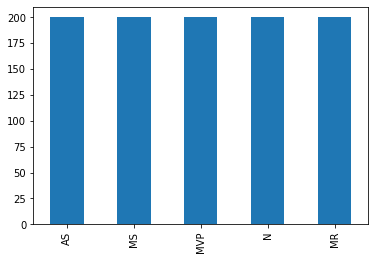

In [11]:
df['labels'].value_counts().plot.bar();

In [33]:
dblock = DataBlock(blocks= (ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   get_x = lambda x: x,
                   get_y = lambda x: str(x).split('/')[-1].replace('New_','').split('_')[0],
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(24)
                  )


In [38]:
dls.vocab

['AS', 'MR', 'MS', 'MVP', 'N']

In [39]:
dls = dblock.datasets(img_path)
dls[0]

(PILImage mode=RGB size=279x271, TensorCategory(0))

In [35]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 1000 items
2 datasets of sizes 800,200
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      dataset/images/New_MVP_190.png
    applying <lambda> gives
      dataset/images/New_MVP_190.png
    applying PILBase.create gives
      PILImage mode=RGB size=279x271
  Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      dataset/images/New_MVP_190.png
    applying <lambda> gives
      MVP
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=279x271, TensorCategory(3))


Found 1000 items
2 datasets of sizes 800,200
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> Categorize -- {'vocab': None, 'sort': True, 'add

RuntimeError: CUDA error: no kernel image is available for execution on the device

In [40]:
torch.cuda.is_available()

True

In [25]:
dls.train

(#800) [(PILImage mode=RGB size=279x271, TensorCategory(4)),(PILImage mode=RGB size=279x271, TensorCategory(2)),(PILImage mode=RGB size=279x271, TensorCategory(4)),(PILImage mode=RGB size=279x271, TensorCategory(2)),(PILImage mode=RGB size=279x271, TensorCategory(4)),(PILImage mode=RGB size=279x271, TensorCategory(3)),(PILImage mode=RGB size=279x271, TensorCategory(3)),(PILImage mode=RGB size=279x271, TensorCategory(1)),(PILImage mode=RGB size=279x271, TensorCategory(1)),(PILImage mode=RGB size=279x271, TensorCategory(4))...]

In [26]:
dls.valid

(#200) [(PILImage mode=RGB size=279x271, TensorCategory(0)),(PILImage mode=RGB size=279x271, TensorCategory(4)),(PILImage mode=RGB size=279x271, TensorCategory(0)),(PILImage mode=RGB size=279x271, TensorCategory(1)),(PILImage mode=RGB size=279x271, TensorCategory(0)),(PILImage mode=RGB size=279x271, TensorCategory(4)),(PILImage mode=RGB size=279x271, TensorCategory(2)),(PILImage mode=RGB size=279x271, TensorCategory(3)),(PILImage mode=RGB size=279x271, TensorCategory(2)),(PILImage mode=RGB size=279x271, TensorCategory(1))...]

In [90]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y = lambda o: str(o).split('/')[-1].replace('New_','').split('_')[0])
dls=dblock.dataloaders('dataset/images', bs=4)

Could not do one pass in your dataloader, there is something wrong in it


In [81]:
dls = ImageDataLoaders.from_df(df=df,
                               path=img_path,
                               valid_pct = 0.2, 
                               bs = 32, 
                               item_tfms=Resize(224))
dls.show_batch()

Could not do one pass in your dataloader, there is something wrong in it


RuntimeError: CUDA error: no kernel image is available for execution on the device

In [66]:
il = (ImageList.from_df(df=df, path=img_path,cols='fnames')
    .split_by_rand_pct(seed=1)
    .label_from_df(cols='labels')
    .transform(size=224)
    .databunch()
    .normalize())
il

NameError: name 'ImageList' is not defined

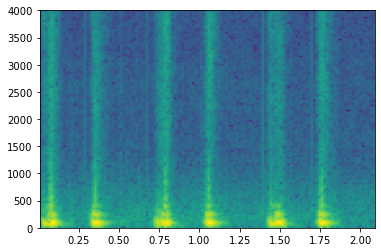

In [55]:
graph_spectrogram('dataset/N/New_N_001.wav')

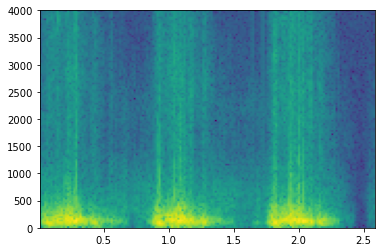

In [56]:
graph_spectrogram(f'{path}/AS/New_AS_001.wav')

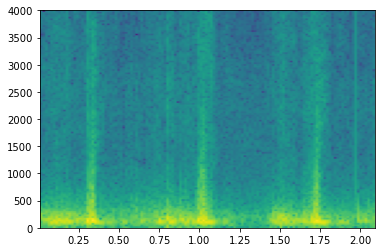

In [57]:
graph_spectrogram(f'{path}/MR/New_MR_001.wav')

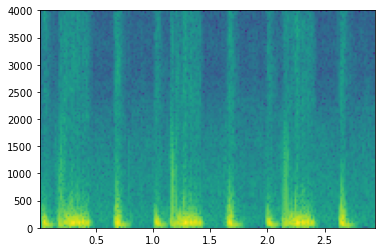

In [58]:
graph_spectrogram(f'{path}/MS/New_MS_001.wav')

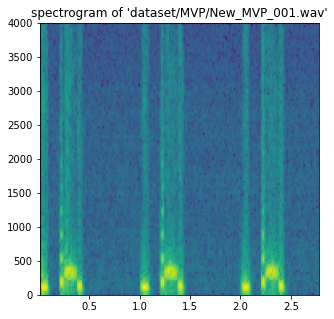

In [32]:
graph_spectrogram(f'{path}/MVP/New_MVP_001.wav')